In [1]:
import numpy as np
import jax
from jax import numpy as jnp
from jax import jit, vmap, grad
from jax import random
from IPython.display import Markdown
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

In [2]:
compound_embedding_path = "/content/drive/MyDrive/LangOn/semanticsNTU/tencent_compounds_embeddings.txt.gz"

In [4]:
import gzip
from tqdm.auto import tqdm
words = []
emb_data = []

with gzip.open(compound_embedding_path, "rt") as fin:
  n_vocab, n_hdim = fin.readline().split(" ")
  n_hdim = int(n_hdim)
  for i in tqdm(range(int(n_vocab))):
    toks = fin.readline().strip().split(" ")
    word = toks[0]
    emb = np.array([float(x) for x in toks[1:]])
    words.append(word)
    emb_data.append(emb)
emb_data = np.vstack(emb_data)

  0%|          | 0/119797 [00:00<?, ?it/s]

In [5]:
# center and normalize all vectors
norm_data = emb_data.copy()
# norm_data = norm_data - norm_data.mean(axis=0)
# norm_data = norm_data / np.linalg.norm(norm_data, axis=1)[:, np.newaxis]

In [6]:
dataset = []
counter = 0
word_map = {w: i for i, w in enumerate(words)}
for word, emb in zip(words, norm_data):
  if len(word) != 4: continue
  compound = word
  w1 = word[:2]
  w2 = word[2:]
  w1_vec = None
  w2_vec = None
  try:
    w1_vec = norm_data[word_map[w1]]
    w2_vec = norm_data[word_map[w2]]
  except KeyError:
    continue
  comp_vec = emb
  rank = counter
  counter += 1
  dataset.append({
      "rank": rank,
      "w1": w1, "w2": w2, "compound": compound,
      "w1_vec": w1_vec, "w2_vec": w2_vec,
      "comp_vec": comp_vec
  })

In [7]:
len(dataset)

75957

In [8]:
@jit
def find_closest(ref_mat, probe):
  return jnp.argmax(jnp.dot(ref_mat, probe))
vmap_find_closest = jit(vmap(find_closest, (None, 0), 0))

In [9]:
probe_vec = jnp.array(norm_data[6555])
find_closest(jnp.array(norm_data), probe_vec)

DeviceArray(6555, dtype=int32)

## Helper functions

$$
AX=B \\
X = (A^\top A)^{-1} A^\top B
$$

In [10]:
def get_train_test_split(dataset, train_offset, train_size, test_offset, test_size):
  train_ds = []
  test_ds = []
  to_idx = lambda x: int(len(dataset)*x)
  train_range = (to_idx(train_offset), to_idx(train_offset)+to_idx(train_size))
  test_range = (to_idx(test_offset), to_idx(test_offset)+to_idx(test_size))
  for idx, entry in enumerate(dataset):
    if train_range[0] < idx < train_range[1] \
       and idx % 10 > 1:
      train_ds.append(entry)
    elif test_range[0] < idx < test_range[1] \
       and idx % 10 <= 1:
      test_ds.append(entry)
  return train_ds, test_ds

def make_data_matrix(ds):
  A = np.vstack([np.hstack([x["w1_vec"], x["w2_vec"]]) for x in ds])
  B = np.vstack([x["comp_vec"] for x in ds])
  return A, B

def compute_X(A, B):
  AtA_inv = np.linalg.inv(np.dot(A.transpose(), A))
  trainX = np.dot(np.dot(AtA_inv, A.transpose()), B)
  return trainX

def pred_B(A, X):
  return np.dot(A, X)

def compute_accuracy(A, B, X, label=""):
  pred_idxs = []
  predB = pred_B(A, X)
  batch_size = 512
  for i in range(0, len(predB), batch_size):
    preds = vmap_find_closest(B, predB[i:i+batch_size])
    pred_idxs.extend(np.asarray(preds).tolist())
  n_correct = sum([x == i for i, x in enumerate(pred_idxs)])
  acc = n_correct/len(pred_idxs)  
  return acc

In [11]:
def run_condition(train_offset, train_size, test_offset, test_size):
  train_ds, test_ds = get_train_test_split(dataset, train_offset, train_size, test_offset, test_size)
  trainA, trainB = make_data_matrix(train_ds)
  testA, testB = make_data_matrix(test_ds)
  X_hat = compute_X(trainA, trainB)
  train_acc = compute_accuracy(trainA, trainB, X_hat, label="train")
  test_acc = compute_accuracy(testA, testB, X_hat, label="test")
  result = (f"| {train_offset*100:.0f}% | {train_size*100:.0f}%"
      f"| {test_offset*100:.0f}% | {test_size*100:.0f}%"
      f"| {len(train_ds)} | {len(test_ds)} | {train_acc:.2f} | {test_acc:.2f} |")
  return result

## Full Testing set

### Full testing, different training size

In [12]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.3, 0., 1.),
    (0., 0.5, 0., 1.),
    (0., 1., 0., 1.),    
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/3 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 30%| 0% | 100%| 18229 | 15191 | 0.50 | 0.53 |
| 0% | 50%| 0% | 100%| 30382 | 15191 | 0.44 | 0.53 |
| 0% | 100%| 0% | 100%| 60765 | 15191 | 0.31 | 0.51 |

### Full testing, different 10% Training

In [13]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.1, 0., 1.),
    (0.1, 0.1, 0., 1.),
    (0.3, 0.1, 0., 1.),
    (0.5, 0.1, 0., 1.),    
    (0.7, 0.1, 0., 1.)
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 10%| 0% | 100%| 6075 | 15191 | 0.65 | 0.50 |
| 10% | 10%| 0% | 100%| 6076 | 15191 | 0.73 | 0.52 |
| 30% | 10%| 0% | 100%| 6074 | 15191 | 0.76 | 0.51 |
| 50% | 10%| 0% | 100%| 6074 | 15191 | 0.75 | 0.49 |
| 70% | 10%| 0% | 100%| 6074 | 15191 | 0.73 | 0.45 |

### Full testing, different 20% Training

In [14]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., 0.2, 0., 1.),
    (0.1, 0.2, 0., 1.),
    (0.3, 0.2, 0., 1.),
    (0.5, 0.2, 0., 1.),    
    (0.7, 0.2, 0., 1.)
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 0% | 100%| 12152 | 15191 | 0.57 | 0.52 |
| 10% | 20%| 0% | 100%| 12152 | 15191 | 0.60 | 0.52 |
| 30% | 20%| 0% | 100%| 12152 | 15191 | 0.64 | 0.51 |
| 50% | 20%| 0% | 100%| 12152 | 15191 | 0.62 | 0.50 |
| 70% | 20%| 0% | 100%| 12152 | 15191 | 0.56 | 0.44 |

## Testing with a fixed 10%

### Testing the first 10% with different training set

In [15]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0., .1),
    (0.3, .2, 0., .1),
    (0.5, .2, 0., .1),
    (0.7, .2, 0., .1),    
]
results = ["",
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/4 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 0% | 10%| 12152 | 1519 | 0.57 | 0.81 |
| 30% | 20%| 0% | 10%| 12152 | 1519 | 0.64 | 0.80 |
| 50% | 20%| 0% | 10%| 12152 | 1519 | 0.62 | 0.79 |
| 70% | 20%| 0% | 10%| 12152 | 1519 | 0.56 | 0.76 |

### Testing the last 10% with different training set

In [17]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0.9, .1),
    (0.3, .2, 0.9, .1),
    (0.5, .2, 0.9, .1),
    (0.7, .2, 0.9, .1),    
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/4 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 90% | 10%| 12152 | 1518 | 0.57 | 0.65 |
| 30% | 20%| 90% | 10%| 12152 | 1518 | 0.64 | 0.65 |
| 50% | 20%| 90% | 10%| 12152 | 1518 | 0.62 | 0.64 |
| 70% | 20%| 90% | 10%| 12152 | 1518 | 0.56 | 0.63 |

## Testing with dataset of the same size, but of different slices

### Test different proportion with the first 20% training set

In [18]:
description = ""
conditions = [
    # train_offset, train_size, test_offset, test_size
    (0., .2, 0.1, .1),
    (0., .2, 0.2, .1),
    (0., .2, 0.3, .1),
    (0., .2, 0.4, .1),
    (0., .2, 0.5, .1),
    (0., .2, 0.6, .1),
    (0., .2, 0.7, .1),
    (0., .2, 0.8, .1),    
    (0., .2, 0.9, .1),    
]
results = [description, 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/9 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 20%| 10% | 10%| 12152 | 1518 | 0.57 | 0.85 |
| 0% | 20%| 20% | 10%| 12152 | 1518 | 0.57 | 0.82 |
| 0% | 20%| 30% | 10%| 12152 | 1520 | 0.57 | 0.84 |
| 0% | 20%| 40% | 10%| 12152 | 1518 | 0.57 | 0.85 |
| 0% | 20%| 50% | 10%| 12152 | 1520 | 0.57 | 0.81 |
| 0% | 20%| 60% | 10%| 12152 | 1518 | 0.57 | 0.81 |
| 0% | 20%| 70% | 10%| 12152 | 1520 | 0.57 | 0.80 |
| 0% | 20%| 80% | 10%| 12152 | 1518 | 0.57 | 0.78 |
| 0% | 20%| 90% | 10%| 12152 | 1518 | 0.57 | 0.65 |

### Test different proportion with the last 20% training set

In [19]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (.8, .2, 0.1, .1),
    (.8, .2, 0.2, .1),
    (.8, .2, 0.3, .1),
    (.8, .2, 0.4, .1),
    (.8, .2, 0.5, .1),
    (.8, .2, 0.6, .1),
    (.8, .2, 0.7, .1),    
    (.8, .2, 0.8, .1),    
    (.8, .2, 0.9, .1),    
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/9 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 80% | 20%| 10% | 10%| 12152 | 1518 | 0.43 | 0.77 |
| 80% | 20%| 20% | 10%| 12152 | 1518 | 0.43 | 0.77 |
| 80% | 20%| 30% | 10%| 12152 | 1520 | 0.43 | 0.78 |
| 80% | 20%| 40% | 10%| 12152 | 1518 | 0.43 | 0.77 |
| 80% | 20%| 50% | 10%| 12152 | 1520 | 0.43 | 0.76 |
| 80% | 20%| 60% | 10%| 12152 | 1518 | 0.43 | 0.72 |
| 80% | 20%| 70% | 10%| 12152 | 1520 | 0.43 | 0.71 |
| 80% | 20%| 80% | 10%| 12152 | 1518 | 0.43 | 0.69 |
| 80% | 20%| 90% | 10%| 12152 | 1518 | 0.43 | 0.58 |

## Effect of training size

In [20]:
conditions = [
    # train_offset, train_size, test_offset, test_size
    (.0, .1, 0.1, .2),        
    (.0, .2, 0.1, .2),        
    (.0, .3, 0.1, .2),        
    (.0, .4, 0.1, .2),        
    (.0, .6, 0.1, .2),        
]
results = ["", 
           "| Train Offset | Train Ratio | Test Offset | TestRatio | "
           "Train Size | Test Size | Train Acc | Test Acc |", 
           "|-----|-----|-----|-----|------:|------:|-----------:|----------:|"]
for cond_x in tqdm(conditions):
  results.append(run_condition(*cond_x))
Markdown("\n".join(results))

  0%|          | 0/5 [00:00<?, ?it/s]


| Train Offset | Train Ratio | Test Offset | TestRatio | Train Size | Test Size | Train Acc | Test Acc |
|-----|-----|-----|-----|------:|------:|-----------:|----------:|
| 0% | 10%| 10% | 20%| 6075 | 3038 | 0.65 | 0.75 |
| 0% | 20%| 10% | 20%| 12152 | 3038 | 0.57 | 0.77 |
| 0% | 30%| 10% | 20%| 18229 | 3038 | 0.50 | 0.78 |
| 0% | 40%| 10% | 20%| 24304 | 3038 | 0.47 | 0.79 |
| 0% | 60%| 10% | 20%| 36458 | 3038 | 0.42 | 0.78 |

## Eyeballing prediction errors

In [21]:
def rank_predictions(ref_mat, probe):
  pred_idxs = jnp.argsort(-jnp.dot(ref_mat, probe))
  return pred_idxs[:10]
vmap_rank_predictions = jit(vmap(rank_predictions, (None, 0), 0))

In [22]:
train_ds, test_ds = get_train_test_split(dataset, 0., .2, .1, .2)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)
B_hat = pred_B(testA, X_hat)

In [23]:
predictions = []
batch_size = 256
for i in tqdm(range(0, B_hat.shape[0], batch_size)):
  preds_sorted = vmap_rank_predictions(testB, B_hat[i:i+batch_size])
  predictions.append(np.asarray(preds_sorted))
predictions = np.vstack(predictions)

  0%|          | 0/12 [00:00<?, ?it/s]

In [24]:
errors = []
for i in range(predictions.shape[0]):
  if predictions[i,0] == i: continue
  errors.append((
      test_ds[i]["compound"],
      [test_ds[pred_idx]["compound"] for pred_idx in predictions[i]]
  ))

In [25]:
print(*[f"{x[0]}: {' '.join(x[1])}" for x in errors[-10:]], sep="\n")

计算单位: 应纳税款 委托单位 统筹基金 独立核算 法人企业 利息损失 长度单位 单项工程 公证机构 票面金额
混合结构: 体积分数 电子结构 催化活性 动物细胞 固体材料 原子结构 真核生物 化学介质 定子绕组 拓扑结构
实况转播: 助理裁判 单场比赛 混双决赛 竞赛规程 赛事奖金 女子足球 实况转播 现场解说 球员得分 比赛场馆
权利保护: 民事权益 财产权益 权利保护 基本权利 司法权威 管理职责 权益保障 个人权益 民主管理 公民权利
基因研究: 生殖细胞 真核生物 基因研究 病毒基因 基因治疗 动物模型 动物细胞 人类疾病 人类基因 遗传因子
儿童时代: 性别意识 智力发展 心理发展 儿童时代 儿童生活 小学生活 儿童发展 孩子年龄 快乐童年 儿童健康
设计课程: 学位课程 核心课程 本科课程 设计课程 语言课程 考试课程 设计基础 工程力学 设计理论 课程特色
政府事务: 财政收支 侨务工作 行政权力 国家权力 政府行政 政府职能 政府事务 民主决策 议事规则 人民民主
华人文化: 客家文化 侨务工作 音乐文化 世界文明 语言文化 运河文化 华人文化 道教文化 文化魅力 京剧艺术
学术成绩: 联考成绩 学术成绩 学科排名 竞赛成绩 本科课程 世界大学 学位课程 学术评价 亚裔学生 本科教学


## Visualize Projection Matrix

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### First 20% of training data
```
Train Offset	Train Ratio	Test Offset	TestRatio	Train Size	Test Size	Train Acc	Test Acc
0%	20%	10%	20%	12152	3038	0.57	0.77
```

In [27]:
train_ds, test_ds = get_train_test_split(dataset, 0., .2, .1, .2)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)

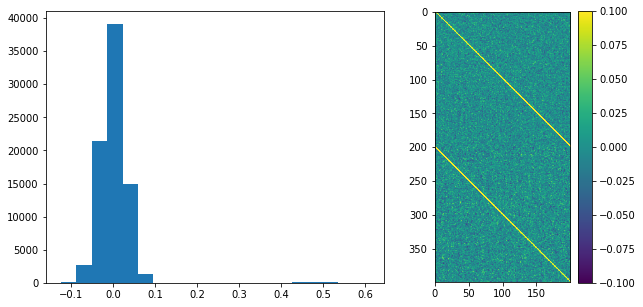

In [28]:
plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
plt.subplot(gs[0])
plt.hist(X_hat.flatten(), bins=20)
plt.subplot(gs[1])
plt.imshow(X_hat, vmin=-0.1, vmax=0.1)
plt.colorbar()

### Full data

```
Train Offset	Train Ratio	Test Offset	TestRatio	Train Size	Test Size	Train Acc	Test Acc
0%	100%	0%	100%	60765	15191	0.31	0.51
```

In [29]:
train_ds, test_ds = get_train_test_split(dataset, 0., 1., 0., 1.)
trainA, trainB = make_data_matrix(train_ds)
testA, testB = make_data_matrix(test_ds)
X_hat = compute_X(trainA, trainB)

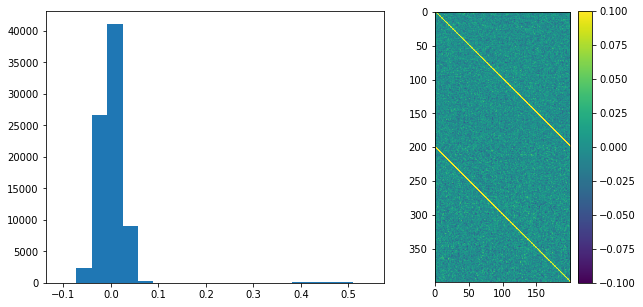

In [30]:
plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2,width_ratios=[2,1])
plt.subplot(gs[0])
plt.hist(X_hat.flatten(), bins=20)
plt.subplot(gs[1])
plt.imshow(X_hat, vmin=-0.1, vmax=0.1)
plt.colorbar()